In [1]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 134443 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.17-0ubuntu2~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.17-0ubuntu2~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope

In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive
import os
os.chdir("drive/colab") 

In [0]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import string
import nltk
from nltk.stem.porter import PorterStemmer
import spacy
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from wordcloud import WordCloud

In [0]:
df1 = pd.read_csv('hotel_happy_reviews.csv')
df2 = pd.read_csv('hotel_not_happy_reviews.csv')

<Figure size 648x432 with 0 Axes>

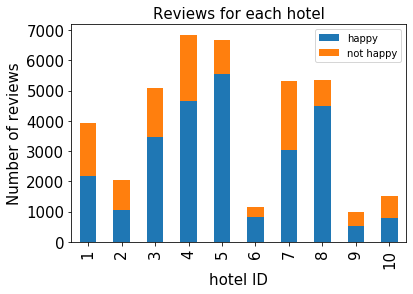

<Figure size 432x288 with 0 Axes>

In [66]:
###happy review for each hotel
happy = df1['hotel_ID'].value_counts()
nothappy = df2['hotel_ID'].value_counts()
dd=pd.DataFrame({u'happy':happy, u'not happy':nothappy})
plt.figure(figsize=(9,6))
dd.plot(kind='bar', stacked=True)
plt.title(u"Reviews for each hotel", fontsize = 15)
plt.xlabel(u"hotel ID", fontsize = 15) 
plt.ylabel(u"Number of reviews", fontsize = 15) 
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()
plt.savefig('eda.png')

In [12]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## text clean

In [0]:
nlp = spacy.load("en_core_web_sm")
stemmer = PorterStemmer()
stops = set(stopwords.words("english"))
english_punctuations = [',', '.', ':', ';', '?', '(', ')', '[', ']', '&', '!', '*', '@', '#', '$', '%']
candidate_pos = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV']
def text_clean(text):
    text = re.sub(r'(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:\'".,<>?«»“”‘’]))', '', text)
    text = re.sub(r'@[\w]*', '', text)
    text = re.sub(r'#[\w]*', '', text)
    text = re.sub(r'\xa0', '', text)
    text = re.sub(r'://…', '', text)
    text = text.replace('\\w+\\s','')
    text = text.replace('\n','')
    text = text.replace('\d','')
    text = text.replace(r'[^a-zA-Z#]', '')
    text = text.lower()
    # doc=nlp(text)
    # selected_words = []
    # for token in doc:
    #     if token.pos_ in candidate_pos and token.is_stop is False:
    #         selected_words.append(token)
    # text = ' '.join([str(x) for x in selected_words])   
    text = ' '.join([w for w in nltk.word_tokenize(text) if len(w)>3])
    text = ' '.join([stemmer.stem(w) for w in nltk.word_tokenize(text) ])
    text= ' '.join([w for w in nltk.word_tokenize(text) if w not in english_punctuations])
    text = ' '.join([w for w in nltk.word_tokenize(text) if w not in stops])

    
    return text

In [0]:
df1['clean_text'] = df1['Description'].apply(text_clean)

In [0]:
df2['clean_text'] = df2['Description'].apply(text_clean)

In [0]:
from gensim import corpora
from gensim import models


# build lda model

raw = df['clean_text'].apply(lambda x:x.split())
reviews_dict = corpora.Dictionary(raw)
corpus = [reviews_dict.doc2bow(text) for text in raw] # Term Document Frequency
tfidf = models.TfidfModel(corpus) #tfidf model 
reviews_corpus = tfidf[corpus]
lda_review = models.LdaModel(reviews_corpus, id2word=reviews_dict, num_topics=20, passes=2)


In [0]:
df = pd.concat([df1,df2], ignore_index= True)

In [0]:
#Save coprus and dict to disk so that we don't have to repeat the get_topic_features methods
reviews_dict.save('reviews_dict.dict')  # save dict to disk
corpora.MmCorpus.serialize('reviews_corpus.mm', reviews_corpus)  #

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [48]:

import pprint
pp = pprint.PrettyPrinter(depth=6)
pp.pprint(lda_review.print_topics())

[(0,
  '0.010*"inn" + 0.009*"sketchi" + 0.008*"drug" + 0.007*"tenderloin" + '
  '0.005*"swipe" + 0.005*"aloft" + 0.005*"crappi" + 0.004*"tripl" + '
  '0.004*"no-fril" + 0.003*"regul"'),
 (1,
  '0.008*"fail" + 0.008*"seriou" + 0.008*"wasnt" + 0.007*"owner" + '
  '0.007*"forc" + 0.006*"damag" + 0.006*"depress" + 0.006*"slam" + '
  '0.006*"blood" + 0.006*"stain"'),
 (2,
  '0.014*"smelli" + 0.014*"bedbug" + 0.007*"yuck" + 0.006*"so-so" + '
  '0.006*"thu" + 0.005*"radiat" + 0.005*"throw" + 0.005*"grow" + '
  '0.004*"econom" + 0.004*"arm"'),
 (3,
  '0.021*"disgust" + 0.017*"bug" + 0.010*"dirti" + 0.007*"ring" + '
  '0.007*"quinta" + 0.006*"indic" + 0.006*"stain" + 0.006*"accur" + '
  '0.005*"yeah" + 0.005*"sticki"'),
 (4,
  '0.018*"stain" + 0.011*"musti" + 0.010*"peel" + 0.008*"odor" + 0.008*"gross" '
  '+ 0.007*"repair" + 0.006*"dirt" + 0.005*"photo" + 0.005*"frill" + '
  '0.005*"wors"'),
 (5,
  '0.014*"attempt" + 0.008*"imposs" + 0.007*"indiffer" + 0.007*"loos" + '
  '0.007*"creepi" + 0.00

In [49]:

# Metrics used to evaluate LDA models are Perplexity and Coherence Score
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_review.log_perplexity(reviews_corpus))  # a measure of how good the model is. lower the better.


Perplexity:  -10.367063891094848


In [50]:
# # Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_review, texts=df['clean_text'].apply(lambda x:x.split()), dictionary=reviews_dict, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)



Coherence Score:  0.4983904598754423


In [0]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [0]:
# grid search
model_list, coherence_values = compute_coherence_values(reviews_dict, reviews_corpus, df['clean_text'].apply(lambda x:x.split()), 40, 2, 6)

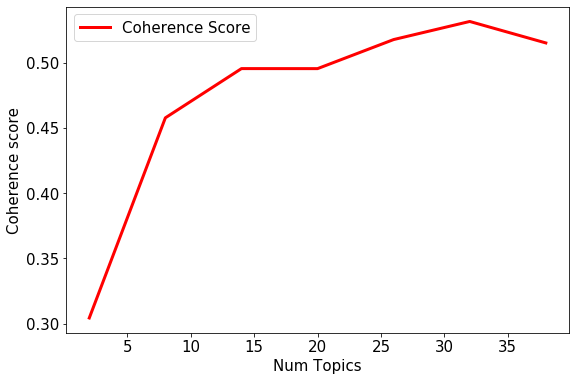

<Figure size 432x288 with 0 Axes>

In [68]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.figure(figsize=(9,6))
plt.plot(x, coherence_values, color = 'red', linewidth = '3')
plt.xlabel("Num Topics", fontsize = 15)
plt.ylabel("Coherence score", fontsize = 15)
plt.legend(["Coherence Score"], fontsize = 15)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.show()
plt.savefig('best_coherence.png')

In [69]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3044
Num Topics = 8  has Coherence Value of 0.4577
Num Topics = 14  has Coherence Value of 0.4954
Num Topics = 20  has Coherence Value of 0.4953
Num Topics = 26  has Coherence Value of 0.5176
Num Topics = 32  has Coherence Value of 0.5314
Num Topics = 38  has Coherence Value of 0.515


In [70]:
#Get the model with the highest coherence scores 
optimal_model = model_list[5]
#what are the words in tops of the optimal model
model_topics = optimal_model.show_topics(formatted=False)
pp.pprint(optimal_model.print_topics(num_words=10))

[(25,
  '0.010*"blame" + 0.008*"redeem" + 0.007*"bunk" + 0.007*"restuar" + '
  '0.006*"crumb" + 0.006*"shoulder" + 0.005*"curb" + 0.005*"zone" + '
  '0.005*"furthermor" + 0.005*"washroom"'),
 (1,
  '0.013*"bland" + 0.013*"overcharg" + 0.012*"sticki" + 0.011*"toler" + '
  '0.010*"clue" + 0.008*"crappi" + 0.007*"awoken" + 0.007*"bleach" + '
  '0.006*"obtain" + 0.006*"fray"'),
 (0,
  '0.014*"overbook" + 0.012*"tissu" + 0.011*"exist" + 0.009*"drab" + '
  '0.009*"appli" + 0.008*"dial" + 0.007*"weekli" + 0.006*"roar" + 0.006*".and" '
  '+ 0.005*"assort"'),
 (4,
  '0.012*"worn" + 0.008*"outdat" + 0.007*"remodel" + 0.007*"non-smok" + '
  '0.007*"wallpap" + 0.007*"pictur" + 0.006*"unfriendli" + 0.006*"advertis" + '
  '0.006*"unabl" + 0.005*"account"'),
 (15,
  '0.020*"yell" + 0.017*"rust" + 0.015*"quinta" + 0.012*"horn" + '
  '0.008*"dreari" + 0.006*"spanish" + 0.005*"stiff" + 0.005*"cleanest" + '
  '0.005*"purs" + 0.004*"shoot"'),
 (2,
  '0.025*"mildew" + 0.018*"lie" + 0.011*"memphi" + 0.010*"

In [0]:
# Save optimal model to disk so we don't need to rerun

optimal_model.save('optimized_model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [0]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):

                wp = ldamodel.show_topic(topic_num) # shows the top 10 words for each topic
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)

    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=reviews_corpus, texts=df.clean_text.astype(str).apply(lambda x:x.split()))


In [72]:
# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,11.0,0.6397,"dirti, thi, night, veri, would, hotel, good, s...","[stay, husband, son, alaska, cruis, love, hote..."
1,1,29.0,0.2061,"peel, woke, crash, reek, accur, file, threadba...","[room, veri, nice, clearli, updat, recent, cle..."
2,2,26.0,0.4181,"night, thi, would, could, good, bathroom, floo...","[wife, stay, thi, gloriou, citi, back, expens,..."
3,3,11.0,0.2126,"dirti, thi, night, veri, would, hotel, good, s...","[boyfriend, stay, fairmont, recent, trip, fran..."
4,4,14.0,0.1938,"scari, repli, grout, edg, potenti, lose, asid,...","[step, time, squar, nice, room, stay, night, g..."
5,5,12.0,0.0420,"poorli, blow, plain, laugh, messag, thanksgiv,...","[wife, kid, stay, valentin, weekend, realli, n..."
6,6,11.0,0.3904,"dirti, thi, night, veri, would, hotel, good, s...","[highli, recommend, hawthorn, terrac, afford, ..."
7,7,26.0,0.3505,"night, thi, would, could, good, bathroom, floo...","[found, hotel, clean, nice, locat, good, free,..."
8,8,29.0,0.0949,"peel, woke, crash, reek, accur, file, threadba...","[stay, elan, octob, like, much, return, trip, ..."
9,9,4.0,0.0575,"worn, outdat, remodel, non-smok, wallpap, pict...","[stay, night, realli, happi, locat, min, walk,..."


In [0]:
# df_dominant_topic.shape
#combined dominant topic with orginal dataframe 
reviews_dominant_topic =df.merge(df_dominant_topic, left_index=True, right_on='Document_No')
reviews_dominant_topic=reviews_dominant_topic.drop(['User_ID', 'Text'], axis = 1)

In [0]:
#save output 
reviews_dominant_topic.to_csv("reviews_df_dominant-topics.csv", index=False)

In [77]:
reviews_dominant_topic.head()

,Description,Is_Response,hotel_ID,clean_text,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,Stayed here with husband and sons on the way t...,happy,8,stay husband son alaska cruis love hotel great...,0,11.0,0.6397,"dirti, thi, night, veri, would, hotel, good, s..."
1,We had - rooms. One was very nice and clearly ...,happy,3,room veri nice clearli updat recent clean comf...,1,29.0,0.2061,"peel, woke, crash, reek, accur, file, threadba..."
2,My wife & I stayed in this glorious city a whi...,happy,3,wife stay thi gloriou citi back expens found t...,2,26.0,0.4181,"night, thi, would, could, good, bathroom, floo..."
3,My boyfriend and I stayed at the Fairmont on a...,happy,7,boyfriend stay fairmont recent trip francisco ...,3,11.0,0.2126,"dirti, thi, night, veri, would, hotel, good, s..."
4,"Steps off Times Square, nice rooms, stayed - n...",happy,3,step time squar nice room stay night great sho...,4,14.0,0.1938,"scari, repli, grout, edg, potenti, lose, asid,..."


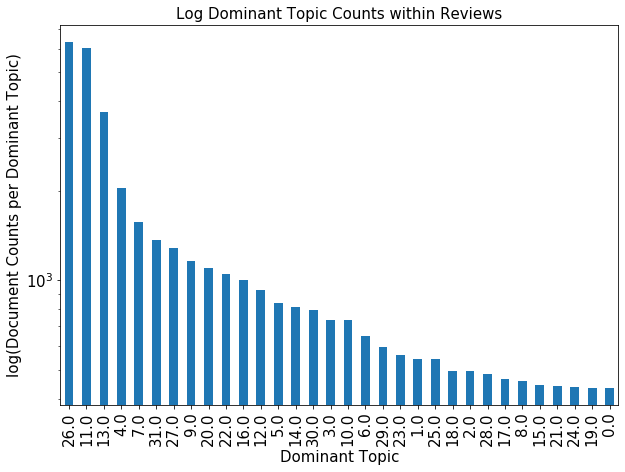

In [93]:

# # Number of Documents for Each Topic

topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()
ax = topic_counts.plot(kind='bar', logy=True,fontsize=15, figsize=(10,7))
ax.set_title("Log Dominant Topic Counts within Reviews", fontsize=15)
ax.set_ylabel("log(Document Counts per Dominant Topic)", fontsize=15);
ax.set_xlabel("Dominant Topic", fontsize=15);
plt.savefig('overall.png')


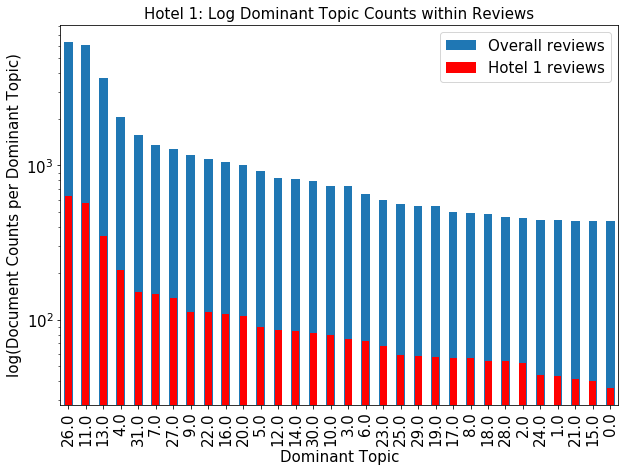

In [92]:
# # Number of Documents for Hotel 1
df_dominant_topic = pd.read_csv('reviews_df_dominant-topics.csv')
topic_counts = df_dominant_topic['Dominant_Topic'].value_counts()
ax = topic_counts.plot(kind='bar', logy=True,fontsize = 15, legend=True,figsize=(10,7))

df_dominant_topic.Dominant_Topic[df_dominant_topic.hotel_ID ==1].value_counts().plot(kind='bar', color = 'red', width=.4,  logy=True)
ax.legend(["Overall reviews", "Hotel 1 reviews"], fontsize =15);
ax.set_title("Hotel 1: Log Dominant Topic Counts within Reviews", fontsize=15)
ax.set_ylabel("log(Document Counts per Dominant Topic)", fontsize=15);
ax.set_xlabel("Dominant Topic", fontsize=15);
plt.savefig('hotel1.png')